## Data Insights on Stanford Sentiment Treebank

The Stanford Sentiment Treebank Dataset contains fully labeled parse trees giving us sentiment for each word and well as phrases that can be obtained by performing constituency parsing of the trees.

One of the first goals is to examine how each class labels are distributed throughout the training data set.

### Class label distribution in training data.

One of the main goals of the experiment is to model the dataset based on 

In [1]:
# Imports
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Set path for models
PROJ_ROOT = os.pardir
sys.path.append(PROJ_ROOT)
from src.features.tree import Tree
from src.models.data_manager import DataManager

In [3]:
# Function to get class distribution in a node
label_size = 5
def get_num_labels(node):
    """Function to get number of labels of each type under a given tree structure."""
    r = np.zeros(label_size)
    r[node.label] = 1
    if node.isLeaf:
        return r
    else:
        return get_num_labels(node.left) + get_num_labels(node.right) + r

# Get parsed trees
trees_path = '../src/data/interim/trainDevTestTrees_PTB/trees/'
x_train = DataManager(trees_path).x_train

y = np.zeros(label_size)
for i in range(len(x_train)):
    y += get_num_labels(x_train[i].root)

print('Class Distribution of Sentiment Labels: {0}'.format(y))

Class Distribution of Sentiment Labels: [  8245.  34362. 219788.  44194.  11993.]


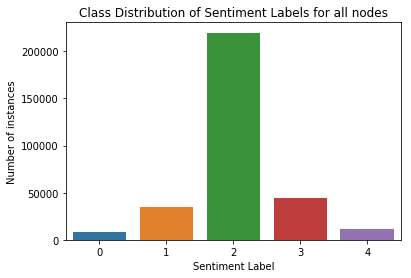

In [16]:
# Plot the distribution
_ = sns.barplot(list(range(5)), y)
_ = plt.xlabel('Sentiment Label')
_ = plt.ylabel('Number of instances')
_ = plt.title('Class Distribution of Sentiment Labels for all nodes')

The class distribution is very heavily skewed towards neutral values. This class imbalance will influence the training of neural network and needs to be handled.

In [19]:
y_root = np.zeros(label_size)
for i in range(len(x_train)):
    r = np.zeros(label_size)
    r[x_train[i].root.label] = 1
    y_root += r

print('Class Distribution of Root Sentiment Labels: {0}'.format(y_root))

Class Distribution of Root Sentiment Labels: [1092. 2218. 1624. 2322. 1288.]


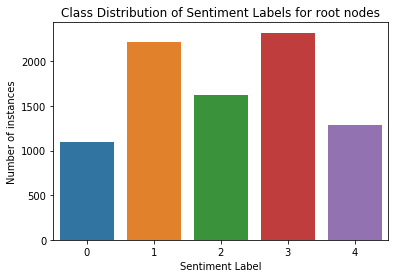

In [20]:
# Plot the distribution of nodes for root nodes
_ = sns.barplot(list(range(5)), y_root)
_ = plt.xlabel('Sentiment Label')
_ = plt.ylabel('Number of instances')
_ = plt.title('Class Distribution of Sentiment Labels for root nodes')

The nodes for root sentiment labels are more evenly distributed, and the minor class imbalance will again be corrected for training.

In [33]:
### Top Positive and Negative words

from collections import defaultdict, Counter

vocab = defaultdict(list)
for i in range(len(x_train)):
    tree = x_train[i]
    stack = [tree.root]
    while stack:
        node = stack.pop()
        if node.isLeaf:
            vocab[node.word].append(node.label)
        else:
            stack.append(node.right)
            stack.append(node.left)

vocab_mean = defaultdict(float)
for k,v in vocab.items():
    vocab_mean[k] = np.mean(v)

In [34]:
positive_words = [x[0] for x in Counter(vocab_mean).most_common(50)]
print('Most positive words: ' + ','.join(positive_words))

Most positive words: charming,playful,astonishing,ingeniously,fun,pure,excellent,award-winning,terrific,Freedom,love,Great,creative,humor,great,beautiful,pleasure,better,sweet,perfect,smart,best,happy,funniest,glorious,delightful,honest,joy,masterpiece,fresh,slam-dunk,encourage,entertaining,impressive,brilliantly,shines,powerful,thoughtful,Oscar-worthy,nicest,pretty,remarkable,laughing,marvelous,worthy,laughter,enthralling,captivating,goodies,Oscar-sweeping


In [35]:
negative_words = [i[0] for i in sorted(vocab.items(), key=lambda x: x[1])]
print('Most negative words: ' + ','.join(negative_words[:20]))

Most negative words: Goddammit,Flawed,artless,bitchy,bruised,negativity,inferior,disinterest,disappoints,cringe,downer,grotesquely,horrendously,Snide,cold-fish,dehumanizing,pissed,trash-cinema,car-wreck,stalking


The sentiments for both kinds of words match expectations. One of the cross-checks would be to validate the generated word-embeddings against these sentiment values.